In [8]:
import pandas as pd
import numpy as np
# I made a change

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
def drop_id(data):
    data.drop('id', axis = 1, inplace = True)

In [11]:
test_id = test['id']

In [12]:
data = [train, test]
for i in data:
    drop_id(i)

<Axes: >

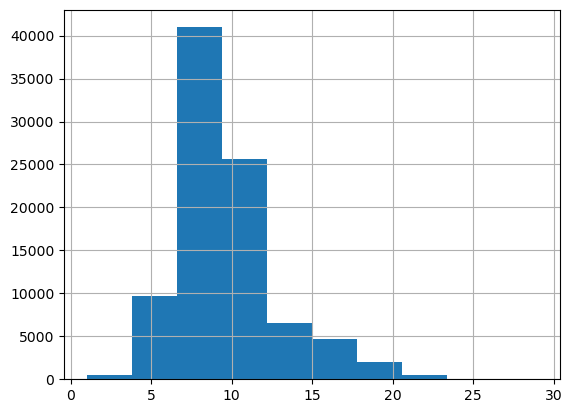

In [13]:
#Our y has a normal distribution so we do not need to transform it
train['Rings'].hist()

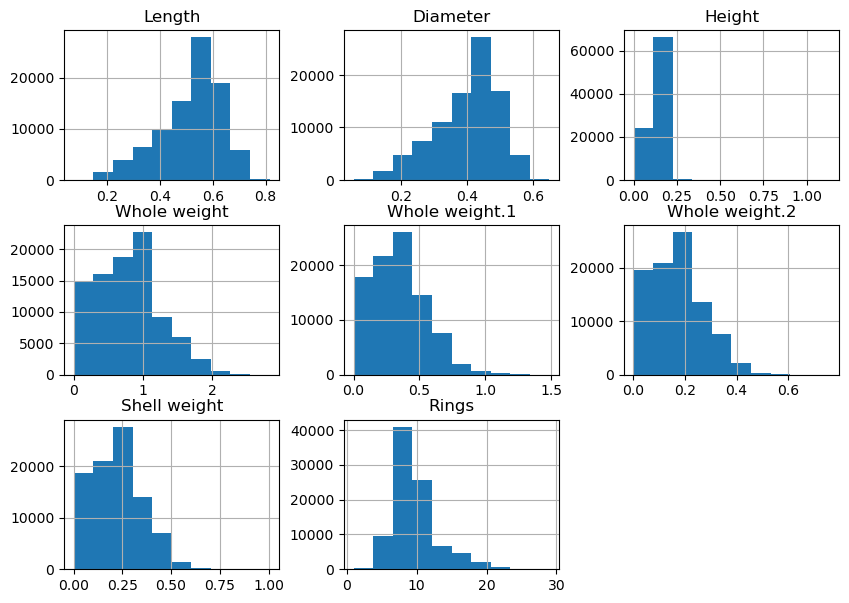

In [14]:
#we can see that our predictors are skewed, especially height might be problematic
train.hist(figsize = (10,7));

In [15]:
train.dtypes #only sex is categorical

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
train = pd.concat([pd.DataFrame(encoder.fit_transform(train[['Sex']]).astype(int),columns = encoder.categories_[0]), 
                   train.iloc[:,1:]] ,axis = 1)


In [17]:
test = pd.concat([pd.DataFrame(encoder.transform(test[['Sex']]).astype(int), columns = encoder.categories_[0]),
                  test.iloc[:,1:]], axis= 1)


In [18]:
target = train['Rings']
train.drop('Rings', axis = 1, inplace = True)

In [19]:
cat_var = ["F","I","M"]
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
column_names = train.iloc[:,3:len(train)-1].columns.tolist()
cont_train_scaled = scaler.fit_transform(train.iloc[:,3:])
train_scaled = pd.DataFrame(cont_train_scaled, columns = column_names)

In [20]:
column_names = test.iloc[:,3:].columns.tolist()
cont_test_scaled = scaler.transform(test.iloc[:,3:])
test_scaled = pd.DataFrame(cont_test_scaled, columns = column_names)

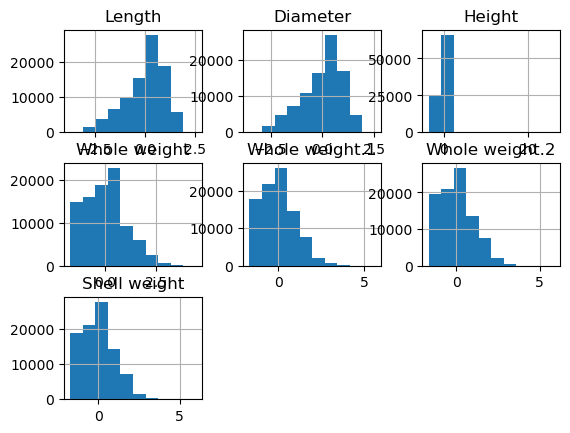

In [21]:
train_scaled.hist();

In [22]:
from scipy.stats import yeojohnson

transformed_train = train_scaled.copy()

for column in train_scaled.columns:
    transformed_train[column], _ = yeojohnson(train_scaled[column])

In [23]:
transformed_test = test_scaled.copy()

for column in test_scaled.columns:
    transformed_test[column], _ = yeojohnson(test_scaled[column])

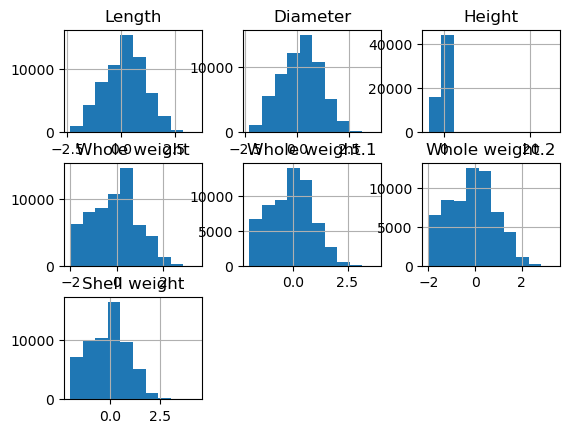

In [24]:
transformed_test.hist();

In [25]:
train_ready = pd.concat([train.iloc[:,:3], transformed_train], axis = 1)

In [26]:
test_ready = pd.concat([test.iloc[:,:3], transformed_test], axis = 1)

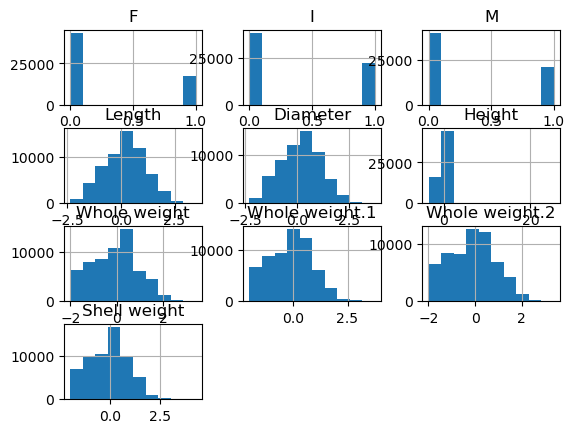

In [27]:
test_ready.hist();

<Axes: >

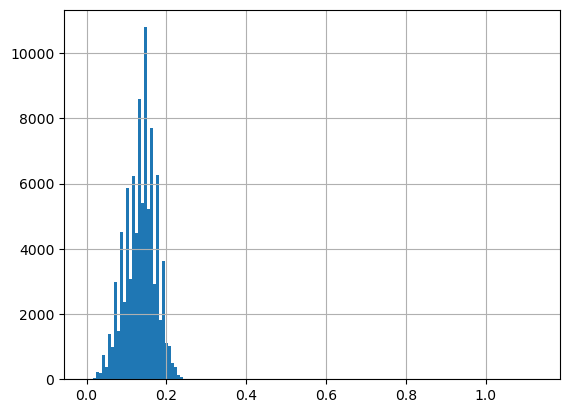

In [28]:
#height is also normally distributed
train['Height'].hist(bins = 150)

In [29]:
#transform the target
log_target = np.log(1+target)
#we will submit answer as np.exp(y) -1

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_ready, log_target, test_size = .2, random_state = 42)

In [31]:
X_train.shape

(72492, 10)

In [39]:
#Modeling plan, first check linaer regression, then different regression and apply regularizations
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [40]:
from sklearn.metrics import mean_squared_error
y = lin_reg.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.1706071103867941

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
train_poly = poly_features.fit_transform(train_ready)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_poly, log_target, test_size = .2, random_state = 42)

In [43]:
#polynomial terms seem to help
lin_reg.fit(X_train, y_train)
y = lin_reg.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.1583030446782785

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_ready, log_target, test_size = .2, random_state = 42)

In [45]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

SGDRegressor()

In [46]:
y = sgd.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.17120060302725448